## Dataset
We first need to prepare dataset to train our model on before we could use it for image classification. To do so, let's define a simple function to use `duckduckgo_search` to download images.

In [7]:
import requests
import os
from fastai.vision.all import *

from duckduckgo_search import DDGS

base_path="data"
tmp_path='tmp'

os.makedirs(base_path, exist_ok=True)

def get_images(keywords, count):
    results = DDGS().images(
        keywords=keywords,
        max_results=count,
    )
    image_urls = [result['image'] for result in results]  # List comprehension
    return image_urls

Download 50 images of dogs and 50 images of cats (you can download any kind of images you want to classify).

In [ ]:
# download dogs images
dogs = get_images("dogs and puppies", 50)
download_images(f"{base_path}/dogs", null, dogs)

In [ ]:
# download cats images
cats = get_images("cats and kittens", 50)
all = [*cats, *kittens]
download_images(f"{base_path}/cats", null, all)

Download images are of various sizes, let's resize them (by cropping) to a standard size (400px)

In [ ]:
# resize images
resize_images(f"{base_path}/dogs", max_size=400, dest=f"{base_path}/dogs")
resize_images(f"{base_path}/cats", max_size=400, dest=f"{base_path}/cats")

Next, remove any image that the process is not able to read/open

In [8]:
#remove failed images
failed = verify_images(get_image_files(base_path))
failed.map(Path.unlink)
print(len(failed))

0


Use fastai Dataloaders to load our dataset. Read more: https://docs.fast.ai/data.load.html

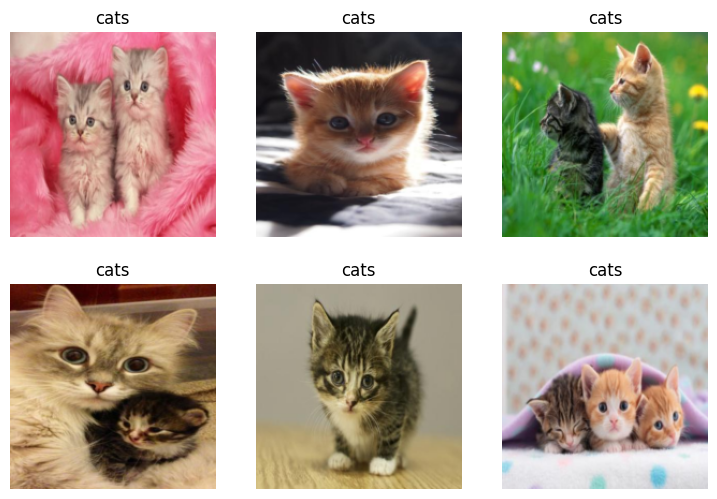

In [14]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(base_path, bs=32)

# show a sample batch
dls.show_batch(max_n=6)

epoch,train_loss,valid_loss,error_rate,time
0,0.994606,0.219158,0.117647,00:01
1,0.617757,0.007856,0.000000,00:00
2,0.443441,0.058554,0.029412,00:00


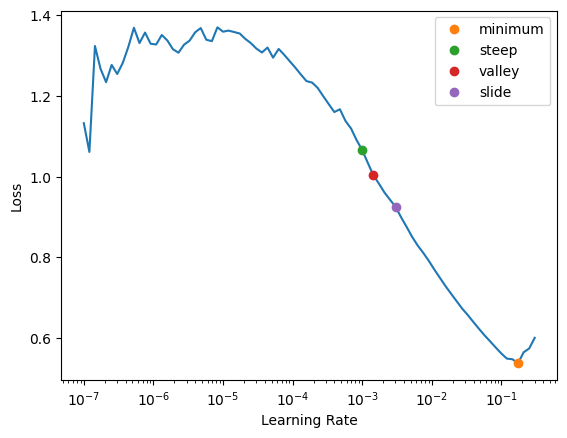

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate) #using resnet18 pretrained model

#find learning rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

#train the model
learn.fit_one_cycle(3,slice(lrs.minimum,lrs.slide))

In [ ]:
# prepare test data
def copy_and_rename_images(source_folder, destination_folder):
    source_path = Path(source_folder)
    destination_path = Path(destination_folder)
    
    # Create destination folder if it does not exist
    destination_path.mkdir(parents=True, exist_ok=True)
    
    # Get all image files including those in subfolders
    image_files = get_image_files(source_path)
    
    # Copy and rename images
    for i, file in enumerate(image_files):
        parent_folder_name = file.parent.name
        new_filename = f"{parent_folder_name}_{i+1}{file.suffix}"
        shutil.copy(file, destination_path / new_filename)

copy_and_rename_images(base_path, tmp_path) # copy files to tmp folder

In [11]:
randoms = get_files(tmp_path)  # Assuming this returns a list of Image objects

# try out our trained model
for image in randoms:
    label_prediction, _, probs = learn.predict(image) 
    if label_prediction not in str(image): 
        print(f"Label: {label_prediction}. Filename: {image}") 


Label: dogs. Filename: tmp/cats_147.jpg


Label: dogs. Filename: tmp/cats_98.jpg


In [16]:
#export the model (used in the chapter 2 for deployment)
learn.export('model.pkl')